In [19]:
# # Disable tf's logging
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

from IPython.display import Audio

import logging
logging.basicConfig()
logging.getLogger('dpmhm').setLevel(10)

import dpmhm
import dpmhm.datasets

In [20]:
TFDS_DATA_DIR = os.path.expanduser('~/tensorflow_datasets/')

In [21]:
# !cd ~/tmp
# !unzip /phm2022.zip

In [22]:
_ = dpmhm.datasets.install('PHM2022', 
                            data_dir=TFDS_DATA_DIR,                           
                            manual_dir=os.path.expanduser('~/tmp/phm2022')
                          )

DEBUG:dpmhm.datasets:Building the dataset...


In [23]:
dataset_name = 'PHM2022'

ds_all, ds_info = tfds.load(
    dataset_name, 
    data_dir=TFDS_DATA_DIR,
    # split=['train[:75%]', 'train[75%:]'],   
    # split=['all'],
    with_info=True,
    # batch_size=-1,  # load the whole dataset into a single batch
)

print(ds_all.keys())  # show the split of the raw dataset

ds0 = ds_all['train']

dict_keys(['test', 'train', 'val'])


In [24]:
ds0.cardinality().numpy()

102435

In [25]:
eles = list(ds0.take(10).as_numpy_iterator())

eles[0]

2024-06-11 11:38:47.113615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'metadata': {'Dataset': b'Data_Challenge_PHM2022_training_data',
  'FileName': b'data_pin4',
  'Label': b'Charge level in high pressure accumulator is low',
  'SensorType': b'pin'},
 'sampling_rate': 50000,
 'signal': {'sig': array([-1.876625e+00, -1.824882e+00, -1.756234e+00, -1.683400e+00,
         -1.588624e+00, -1.414488e+00, -1.146603e+00, -8.325380e-01,
         -6.004600e-01, -5.740730e-01, -7.811020e-01, -1.169988e+00,
         -1.627429e+00, -2.015095e+00, -2.248460e+00, -2.243966e+00,
         -2.128783e+00, -1.989307e+00, -1.906073e+00, -1.782569e+00,
         -1.410182e+00, -5.923180e-01,  2.257500e-01,  3.385720e-01,
          1.148500e-02, -4.720830e-01, -1.228096e+00, -2.167405e+00,
         -2.702106e+00, -2.719501e+00, -2.918007e+00, -3.184928e+00,
         -2.849432e+00, -2.170220e+00, -1.783706e+00, -1.833854e+00,
         -1.824163e+00, -1.925095e+00, -2.403757e+00, -2.623547e+00,
         -2.165794e+00, -1.891086e+00, -2.068016e+00, -2.156129e+00,
         -1.8828

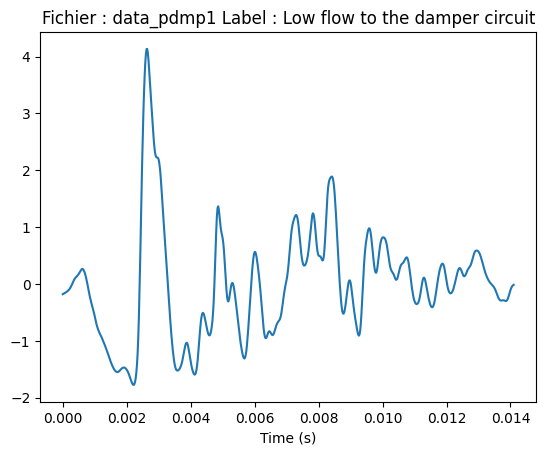

In [26]:
fn = eles[1]['metadata']['FileName'].decode()
sr = eles[1]['sampling_rate']
x = eles[1]['signal']['sig']
label=eles[1]['metadata']['Label'].decode()

plt.figure()
plt.plot(np.arange(len(x))/sr, x)
plt.xlabel('Time (s)')
plt.title('Fichier : '+fn+' Label : '+label)

Audio(x, rate=sr)

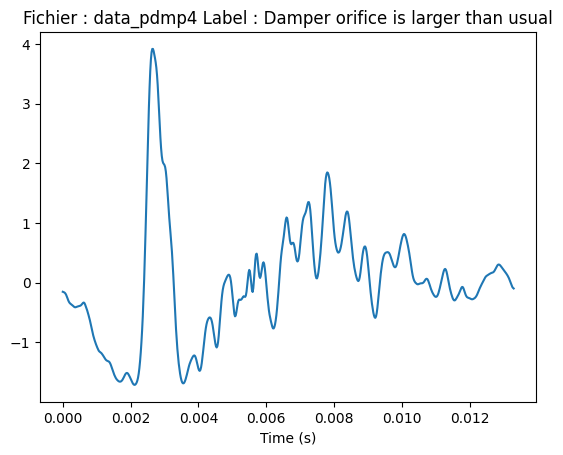

In [27]:
fn = eles[2]['metadata']['FileName'].decode()
sr = eles[2]['sampling_rate']
x = eles[2]['signal']['sig']
label=eles[2]['metadata']['Label'].decode()

plt.figure()
plt.plot(np.arange(len(x))/sr, x)
plt.xlabel('Time (s)')
plt.title('Fichier : '+fn+' Label : '+label)

Audio(x, rate=sr)

In [28]:
# Filter on the channels
channels = ['sig']

# Label ramification
keys = [] 

# Selection of domain
# filters = {'SensorType': [b'pin',b'po']}  # source domain
filters = {}  # no selection

# Resampling rate in Hz
resampling_rate = 50000  # no resampling

# Size of the sliding window (after resampling)
elem=list(ds0.take(5).as_numpy_iterator())
# window_size = resampling_rate  # 1 second
window_size = len(elem[0]['signal']['sig'])

# Number of samples to skip between sucessive window
hop_size = window_size//2

from dpmhm.datasets import transformer

compactor = transformer.DatasetCompactor(ds0, channels=channels, keys=keys, filters=filters,
                                         resampling_rate=resampling_rate, 
                                         window_size=window_size, hop_size=hop_size)

2024-06-11 11:38:47.586355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
ds1 = compactor.dataset

print("Original:", ds0.element_spec['signal'])
print("Compacted:", ds1.element_spec['signal'])


2024-06-11 11:38:47.760458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Original: {'sig': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}
Compacted: TensorSpec(shape=(1, None), dtype=tf.float32, name=None)


In [30]:
eles0 = list(ds0.take(2).as_numpy_iterator())
eles1 = list(ds1.take(2).as_numpy_iterator())

ds1.element_spec

2024-06-11 11:38:47.842433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-11 11:38:47.973342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'label': TensorSpec(shape=(), dtype=tf.string, name=None),
 'sampling_rate': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'signal': TensorSpec(shape=(1, None), dtype=tf.float32, name=None)}

In [31]:
from dpmhm.datasets import feature

# Feature extractor

_func = lambda x, sr: feature.spectral_features(x, sr, 'spectrogram', 
                                                time_window=len(elem[0]['signal']['sig'])/resampling_rate, hop_step=len(elem[0]['signal']['sig'])/(resampling_rate*2), normalize=False,
                                                to_db=True)[0]
# _func = lambda x, sr: feature.spectral_features(x, sr, 'spectrogram', 
                                                # time_window=window_size/resampling_rate, hop_step=window_size/(resampling_rate*2), normalize=False,
                                                # to_db=True)[0]

# print(_func(eles1[0]['signal'][0],50000)[0])
# print(len(_func(eles1[0]['signal'][0],50000)[0]),len(_func(eles1[0]['signal'][0],50000)))
# print(len(eles1[0]['signal'][0]))
# _func = lambda x, sr: feature.spectral_features(x, sr, 'melspectrogram', 
#                                                 time_window=0.025, hop_step=0.0125, normalize=False,
#                                                 feature_kwargs={'n_mels':128})[0]

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

In [32]:
ds2 = extractor.dataset
print(ds2.element_spec)

eles2 = list(ds2.take(2).as_numpy_iterator())

{'label': TensorSpec(shape=(), dtype=tf.string, name=None), 'feature': TensorSpec(shape=(1, None, None), dtype=tf.float32, name=None)}


2024-06-11 11:38:48.196888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: ValueError: window shape cannot be larger than input array shape
Traceback (most recent call last):

  File "/volatile/home/bm279471/Documents/.venv/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/volatile/home/bm279471/Documents/.venv/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/volatile/home/bm279471/Documents/.venv/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/volatile/home/bm279471/Documents/.venv/lib/python3.11/site-packages/dpmhm/datasets/utils.py", line 126, in _generator
    W = s

(1, 513, 3)


Text(0, 0.5, 'Frequency bin')

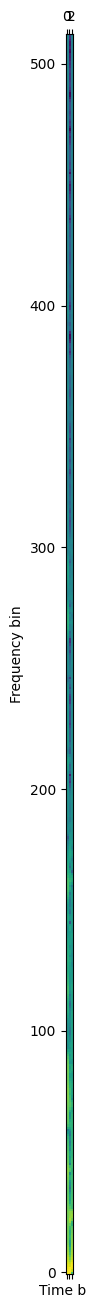

In [33]:
print(eles2[0]['feature'].shape)

X = eles2[0]
plt.matshow(X['feature'][0], origin='lower')
plt.xlabel('Time bin')
plt.ylabel('Frequency bin')